In [ ]:
!pip install pyspark

In [ ]:
#initialize SparkSession and installed Required Libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize SparkSession
spark = SparkSession.builder \
                    .appName("LinearRegression_spark") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()


spark

In [ ]:
print(f"Spark UI available at: {spark.sparkContext.uiWebUrl}")

Spark UI available at: http://45cf00a650f9:4040


In [ ]:
spark.sparkContext.setLogLevel("INFO")

In [ ]:
import psutil
print(f"CPU Usage: {psutil.cpu_percent()}%")
print(f"Memory Usage: {psutil.virtual_memory().percent}%")

CPU Usage: 78.0%
Memory Usage: 13.5%


In [ ]:
# Load the data from a CSV file
df = spark.read.csv("/content/01property.csv", header=True, inferSchema=True)

# get familiar with data
df.show()

# more info
print("Total Records",df.count())
print("Total Partitions ",df.rdd.getNumPartitions())

+--------------+------------+-------------+----------+--------+------------------+
|Square_Footage|Num_Bedrooms|Num_Bathrooms|Year_Built|Lot_Size|             Price|
+--------------+------------+-------------+----------+--------+------------------+
|          1360|           2|            3|      1953|    7860| 303948.1373854071|
|          4272|           3|            3|      1997|    5292| 860386.2685075302|
|          3592|           4|            1|      1983|    9723| 734389.7538956215|
|           966|           6|            1|      1903|    4086| 226448.8070714377|
|          4926|           6|            4|      1944|    1081|1022486.2616704078|
|          3944|           6|            2|      1938|    3542| 845638.1354384426|
|          3671|           2|            1|      1963|    5105| 748779.2192281872|
|          3419|           4|            2|      1925|    5448| 743007.2614135538|
|           630|           2|            2|      2012|    3204| 135656.4528785377|
|   

In [ ]:
# check missing or null values for each column
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c))
.alias(c) for c in df.columns]).show()

+--------------+------------+-------------+----------+--------+-----+
|Square_Footage|Num_Bedrooms|Num_Bathrooms|Year_Built|Lot_Size|Price|
+--------------+------------+-------------+----------+--------+-----+
|             0|           0|            0|         0|       0|    0|
+--------------+------------+-------------+----------+--------+-----+



In [ ]:
from pyspark.sql import SparkSession
from itertools import combinations
from pyspark.ml.feature import VectorAssembler

# Initialize SparkSession
spark = SparkSession.builder \
                    .appName("LinearRegression_spark") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()

'''from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = ["Num_Bathrooms","Year_Built","Lot_Size"],
                           outputCol = "Features")'''


# Available columns
all_columns = ["Square_Footage", "Num_Bedrooms", "Num_Bathrooms", "Year_Built", "Lot_Size"]

target = "Price"

# Loop through combinations of size 4 and 5
for r in [4, 5]:
    for combo in combinations(all_columns, r):
        assembler = VectorAssembler(inputCols=list(combo), outputCol="Features")

        # Example: show which combination is currently being used
        print(f"Using features: {combo} -> target: {target}")

        # Now you can fit or transform your dataset here
        df_transformed = assembler.transform(df)
        df_transformed.select("Features", "Price").show(5, truncate=False)

Using features: ('Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Year_Built') -> target: Price
+-----------------------+------------------+
|Features               |Price             |
+-----------------------+------------------+
|[1360.0,2.0,3.0,1953.0]|303948.1373854071 |
|[4272.0,3.0,3.0,1997.0]|860386.2685075302 |
|[3592.0,4.0,1.0,1983.0]|734389.7538956215 |
|[966.0,6.0,1.0,1903.0] |226448.8070714377 |
|[4926.0,6.0,4.0,1944.0]|1022486.2616704078|
+-----------------------+------------------+
only showing top 5 rows

Using features: ('Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Lot_Size') -> target: Price
+-----------------------+------------------+
|Features               |Price             |
+-----------------------+------------------+
|[1360.0,2.0,3.0,7860.0]|303948.1373854071 |
|[4272.0,3.0,3.0,5292.0]|860386.2685075302 |
|[3592.0,4.0,1.0,9723.0]|734389.7538956215 |
|[966.0,6.0,1.0,4086.0] |226448.8070714377 |
|[4926.0,6.0,4.0,1081.0]|1022486.2616704078|
+-------------

In [ ]:
#StandardScaler
scaler = StandardScaler(inputCol = "Features",
                        outputCol = "scaled_Features")

In [ ]:
#create linear regression model.
regressor = LinearRegression(labelCol = 'price',
                             featuresCol = 'scaled_Features'
                             )

In [ ]:
from pyspark.ml import Pipeline
pipeline  = Pipeline(stages = [assembler,scaler,regressor])
#--Saving the Pipeline
pipeline.write().overwrite().save("pipeline_LRsaved_model")

In [ ]:
#Loading the Pipeline

pipelineModel = Pipeline.load('./pipeline_LRsaved_model')

In [ ]:
data_train , data_test = df.randomSplit([0.7,0.3], seed = 123)

In [ ]:
# Rename the 'Price' column to 'price' to avoid potential case sensitivity issues
data_train = data_train.withColumnRenamed("Price", "price")

# Now fit the pipeline with the modified data_train
Model = pipeline.fit(data_train)

In [ ]:
print("total LR cofficents",len(Model.stages[2].coefficients) )
print("Cofficientents",Model.stages[2].coefficients)
print("Intecept",Model.stages[2].intercept)

total LR cofficents 5
Cofficientents [259713.7417073235,8489.784330534883,3378.7740198882,-3513.271186072594,255.21011993161852]
Intecept 201733.14322794523


In [ ]:
#n the prediction phase, we test our model on some unseen data.
# Rename the 'Price' column to 'price' in the data_test DataFrame
data_test = data_test.withColumnRenamed("Price", "price")

pred = Model.transform(data_test)
pred.select('prediction', 'price').show(10, truncate = False)

+------------------+------------------+
|prediction        |price             |
+------------------+------------------+
|118121.10528354289|117632.63219959654|
|109819.07488583298|106670.25438504865|
|123602.47901155718|117919.45375887671|
|112812.7645693288 |119893.50473253023|
|114455.54351024327|115218.14440379351|
|125803.52503171995|142918.60554292126|
|121763.45102081564|95443.54011673816 |
|114906.14211178281|75029.23686169085 |
|124524.17765361229|128827.18170769783|
|127635.82198153388|131723.44904010184|
+------------------+------------------+
only showing top 10 rows



In [ ]:
Lasoregressor = LinearRegression(labelCol = 'price',
                             featuresCol = 'scaled_Features',
                             elasticNetParam=1,
                             regParam=0.1
                             )
Lasaopipeline  = Pipeline(stages = [assembler,scaler,Lasoregressor])
LassoModel = Lasaopipeline.fit(data_train)

In [ ]:
#n the prediction phase, we test our model on some unseen data.
lassopred = LassoModel.transform(data_test)
lassopred.select('prediction', 'price').show(10, truncate = False)

+------------------+------------------+
|prediction        |price             |
+------------------+------------------+
|118121.55139928522|117632.63219959654|
|109819.72956462958|106670.25438504865|
|123602.52632204814|117919.45375887671|
|112813.2332470289 |119893.50473253023|
|114456.13651147648|115218.14440379351|
|125803.59497237773|142918.60554292126|
|121763.63596307614|95443.54011673816 |
|114906.7293521888 |75029.23686169085 |
|124524.37552737916|128827.18170769783|
|127635.96808516192|131723.44904010184|
+------------------+------------------+
only showing top 10 rows



In [ ]:
#create linear regression model.
Ridgeregressor = LinearRegression(labelCol = 'price',
                             featuresCol = 'scaled_Features',
                             elasticNetParam=0,
                             regParam=0.1
                             )
Ridgepipeline  = Pipeline(stages = [assembler,scaler,Ridgeregressor])
RidgeModel = Ridgepipeline.fit(data_train)

In [ ]:
Ridgepred = RidgeModel.transform(data_test)
Ridgepred.select('prediction', 'price').show(10, truncate = False)

+------------------+------------------+
|prediction        |price             |
+------------------+------------------+
|118121.28242622   |117632.63219959654|
|109819.2554792074 |106670.25438504865|
|123602.65485720341|117919.45375887671|
|112812.9444342232 |119893.50473253023|
|114455.7223523028 |115218.14440379351|
|125803.7000667135 |142918.60554292126|
|121763.62760088671|95443.54011673816 |
|114906.32082975653|75029.23686169085 |
|124524.3530041458 |128827.18170769783|
|127635.99612972766|131723.44904010184|
+------------------+------------------+
only showing top 10 rows



In [ ]:
#Model Evaluation Spark Provides evaluation metrics
#for regression and classification tasks.
from pyspark.ml.evaluation import RegressionEvaluator
evaluator_mse = RegressionEvaluator(labelCol =
                                    'price',
                                    predictionCol =
                                    'prediction',
                                    metricName =
                                    'mse')
# calculate MSE
mse1 = evaluator_mse.evaluate(pred)
mselasso = evaluator_mse.evaluate(lassopred)
mseridge = evaluator_mse.evaluate(Ridgepred )

evaluator_rmse = RegressionEvaluator(labelCol =
                                     'price',
                                     predictionCol =
                                     'prediction',
                                     metricName =
                                     'rmse')
# calculate RMSE
rmse1 = evaluator_rmse.evaluate(pred)
rmse2_lasso = evaluator_rmse.evaluate(lassopred)
rmse3Ridge = evaluator_rmse.evaluate(Ridgepred)

evaluator_r2 = RegressionEvaluator(labelCol = 'price',
                                   predictionCol = 'prediction',
                                   metricName = 'r2')
# calculate R_squared
r2_score1 = evaluator_r2.evaluate(pred)
r2_lasso = evaluator_r2.evaluate(lassopred)
r2_ridge = evaluator_r2.evaluate(Ridgepred)
# print the evaluation metrics
print('Regression - MSE: ', mse1, ', RMSE: ', rmse1, ', R^2: ', r2_score1)
print('Lasso - MSE: ', mselasso, ', RMSE: ', rmse2_lasso, ', R^2: ', r2_lasso)
print('Ridge - MSE: ', mseridge, ', RMSE: ', rmse3Ridge, ', R^2: ', r2_ridge)

Regression - MSE:  397865280.0583338 , RMSE:  19946.560607240885 , R^2:  0.9941460215328993
Lasso - MSE:  397865309.70173943 , RMSE:  19946.561350311473 , R^2:  0.994146021096742
Ridge - MSE:  397865279.7002717 , RMSE:  19946.56059826535 , R^2:  0.9941460215381677


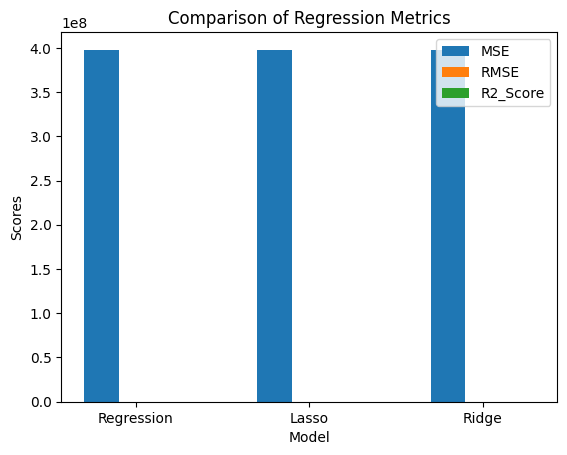

In [ ]:
# plot
import matplotlib.pyplot as plt
import numpy as np

mse = [mse1, mselasso, mseridge]
rmse = [rmse1, rmse2_lasso, rmse3Ridge]
r2_score = [r2_score1, rmse2_lasso, r2_ridge]

positions = np.arange(len(mse))
bar_width = 0.2

plt.bar(positions - bar_width, mse, width = bar_width, label = 'MSE')
plt.bar(positions, rmse, width = bar_width, label = 'RMSE')
plt.bar(positions + bar_width, r2_score, width = bar_width, label = 'R2_Score')

# adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Regression Metrics')

# adding the legend
plt.legend()
plt.xticks(positions, ['Regression', 'Lasso', 'Ridge'])
plt.show()

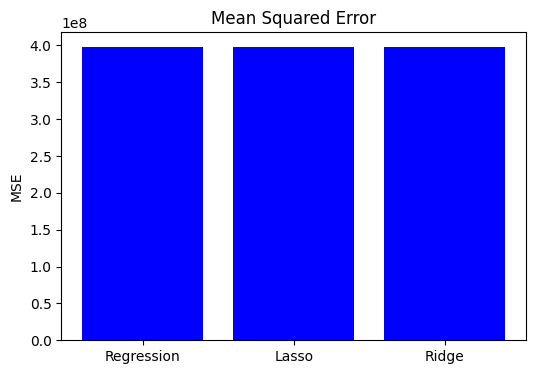

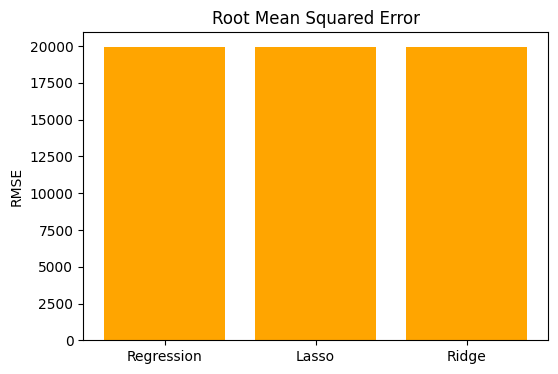

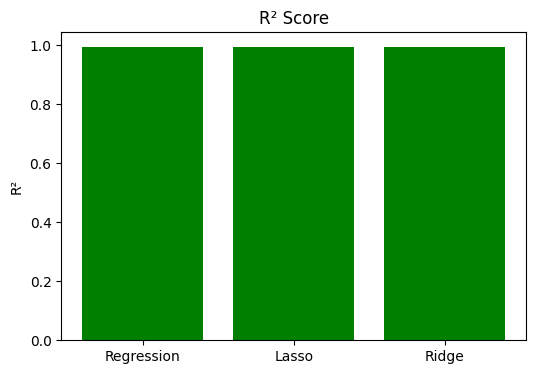

In [ ]:
# Separate plots so each metric is clearly visible
plt.figure(figsize=(6, 4))
plt.bar(["Regression", "Lasso", "Ridge"], [mse1, mselasso, mseridge], color='blue')
plt.title("Mean Squared Error")
plt.ylabel("MSE")
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(["Regression", "Lasso", "Ridge"], [rmse1, rmse2_lasso, rmse3Ridge], color='orange')
plt.title("Root Mean Squared Error")
plt.ylabel("RMSE")
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(["Regression", "Lasso", "Ridge"], [r2_score1, r2_lasso, r2_ridge], color='green')
plt.title("R² Score")
plt.ylabel("R²")
plt.show()

===========================================================================================================================================================

In [ ]:
import pandas as pd
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Load your property dataset
# Replace with your actual CSV or DataFrame variable
df = pd.read_csv("/content/01property.csv")

# All possible features
all_features = ["Square_Footage", "Num_Bedrooms", "Num_Bathrooms", "Year_Built", "Lot_Size"]

# Target column
target = "Price"

results = []

# Loop through combinations of 4 and 5 features
for r in [4, 5]:
    for combo in itertools.combinations(all_features, r):
        # Prepare X and y
        X = df[list(combo)]
        y = df[target]

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create and fit the model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Predict and calculate R²
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)

        # Save results
        results.append({
            "Features": combo,
            "R2_Score": r2
        })

# Convert results to DataFrame and sort
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="R2_Score", ascending=False).reset_index(drop=True)

print("Model Performance Comparison (sorted by R²):")
print(results_df)

# Optional: Save to CSV for your portfolio
results_df.to_csv("model_r2_comparison.csv", index=False)


Model Performance Comparison (sorted by R²):
                                            Features  R2_Score
0  (Square_Footage, Num_Bedrooms, Num_Bathrooms, ...  0.994128
1  (Square_Footage, Num_Bedrooms, Num_Bathrooms, ...  0.994126
2  (Square_Footage, Num_Bedrooms, Year_Built, Lot...  0.993965
3  (Square_Footage, Num_Bedrooms, Num_Bathrooms, ...  0.993941
4  (Square_Footage, Num_Bathrooms, Year_Built, Lo...  0.993053
5  (Num_Bedrooms, Num_Bathrooms, Year_Built, Lot_...  0.001484


======================================================================================================================================================

Model Performance Comparison (sorted by R²):
                                            Features  R2_Score
0  Square_Footage, Num_Bedrooms, Num_Bathrooms, Y...  0.994128
1  Square_Footage, Num_Bedrooms, Num_Bathrooms, Y...  0.994126
2  Square_Footage, Num_Bedrooms, Year_Built, Lot_...  0.993965
3  Square_Footage, Num_Bedrooms, Num_Bathrooms, L...  0.993941
4  Square_Footage, Num_Bathrooms, Year_Built, Lot...  0.993053
5  Num_Bedrooms, Num_Bathrooms, Year_Built, Lot_Size  0.001484


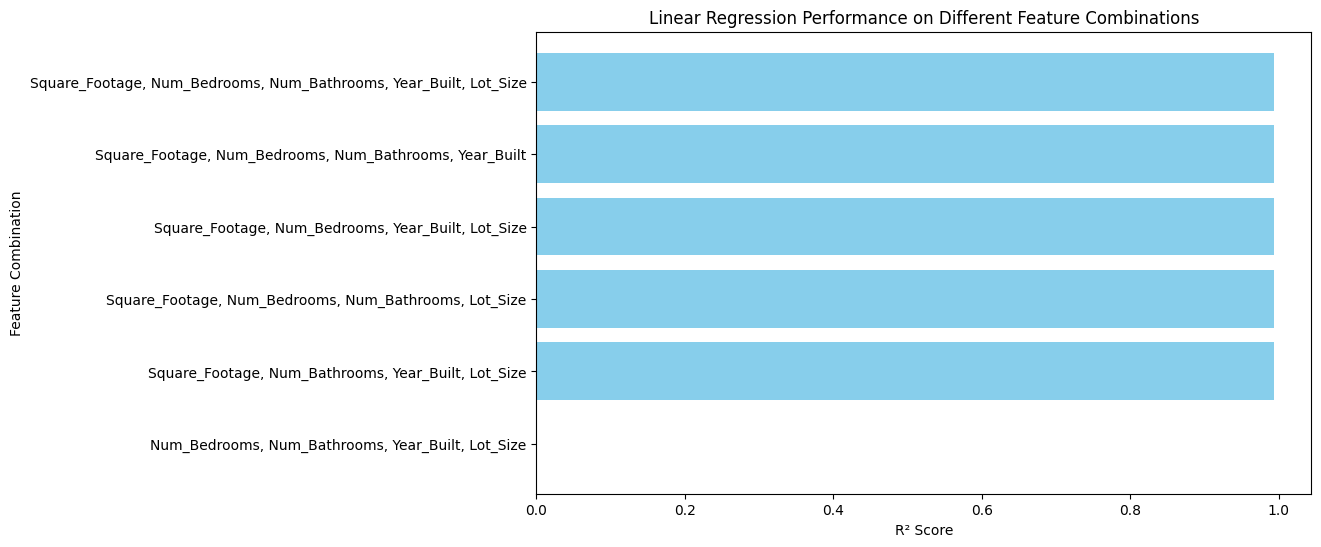

In [ ]:
# -----------------------------
# Import required libraries
# -----------------------------
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# -----------------------------
# Load your dataset
# -----------------------------
# Replace with your actual CSV file path or DataFrame
df = pd.read_csv("/content/01property.csv")

# -----------------------------
# Define possible features & target
# -----------------------------
all_features = ["Square_Footage", "Num_Bedrooms", "Num_Bathrooms", "Year_Built", "Lot_Size"]
target = "Price"

# -----------------------------
# Store results for each combination
# -----------------------------
results = []

# Loop through combinations of 4 and 5 features
for r in [4, 5]:
    for combo in itertools.combinations(all_features, r):
        X = df[list(combo)]
        y = df[target]

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Linear Regression model
        model = LinearRegression()
        model.fit(X_train, y_train)

        # Predictions & R² score
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)

        # Save result
        results.append({
            "Features": ", ".join(combo),
            "R2_Score": r2
        })

# -----------------------------
# Convert results to DataFrame
# -----------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="R2_Score", ascending=False).reset_index(drop=True)

# Display the table
print("Model Performance Comparison (sorted by R²):")
print(results_df)

# -----------------------------
# Plot R² scores for all combinations
# -----------------------------
plt.figure(figsize=(10, 6))
plt.barh(results_df["Features"], results_df["R2_Score"], color='skyblue')
plt.xlabel("R² Score")
plt.ylabel("Feature Combination")
plt.title("Linear Regression Performance on Different Feature Combinations")
plt.gca().invert_yaxis()  # Highest score at top
plt.show()

# -----------------------------
# Save results for portfolio
# -----------------------------
results_df.to_csv("property_model_r2_comparison.csv", index=False)


                                            Features   R2_Score
0  Square_Footage, Num_Bedrooms, Num_Bathrooms, Y... 0.99412770
1  Square_Footage, Num_Bedrooms, Num_Bathrooms, Y... 0.99412628
2  Square_Footage, Num_Bedrooms, Year_Built, Lot_... 0.99396513
3  Square_Footage, Num_Bedrooms, Num_Bathrooms, L... 0.99394054
4  Square_Footage, Num_Bathrooms, Year_Built, Lot... 0.99305318
5  Num_Bedrooms, Num_Bathrooms, Year_Built, Lot_Size 0.00148391


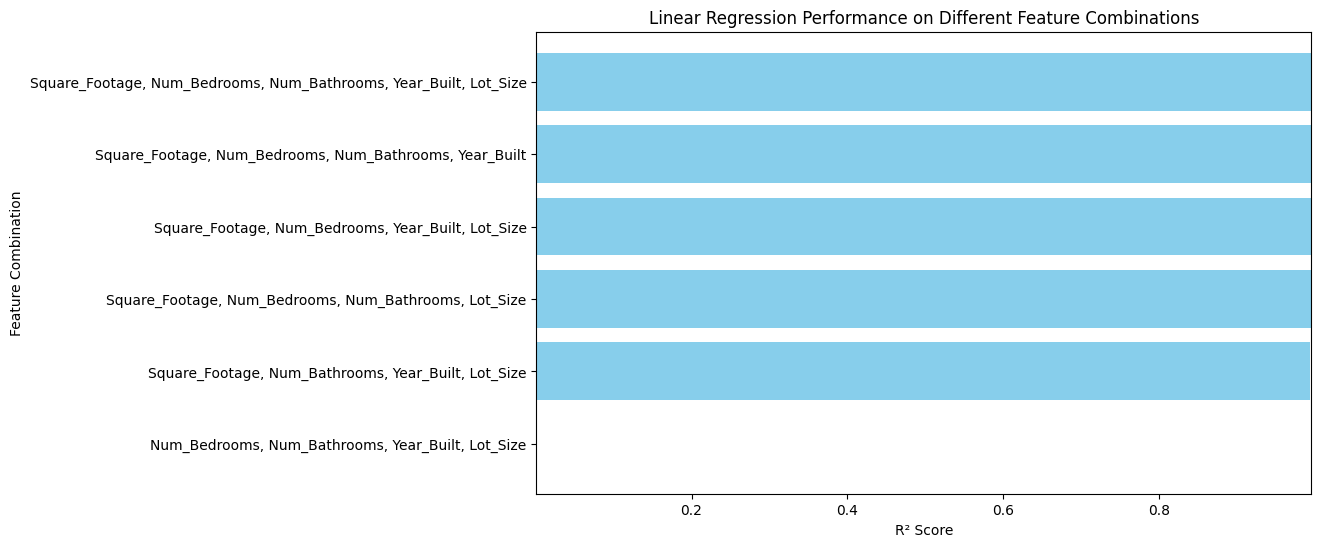

In [ ]:
# Display table with more decimal places
pd.set_option("display.float_format", "{:.8f}".format)
print(results_df)

# Plot with zoomed-in x-axis
plt.figure(figsize=(10, 6))
plt.barh(results_df["Features"], results_df["R2_Score"], color='skyblue')
plt.xlabel("R² Score")
plt.ylabel("Feature Combination")
plt.title("Linear Regression Performance on Different Feature Combinations")
plt.gca().invert_yaxis()

# Zoom in around the range of scores to see differences
min_score = results_df["R2_Score"].min()
max_score = results_df["R2_Score"].max()
plt.xlim(min_score - 0.0005, max_score + 0.0005)  # Adjust range for visibility

plt.show()


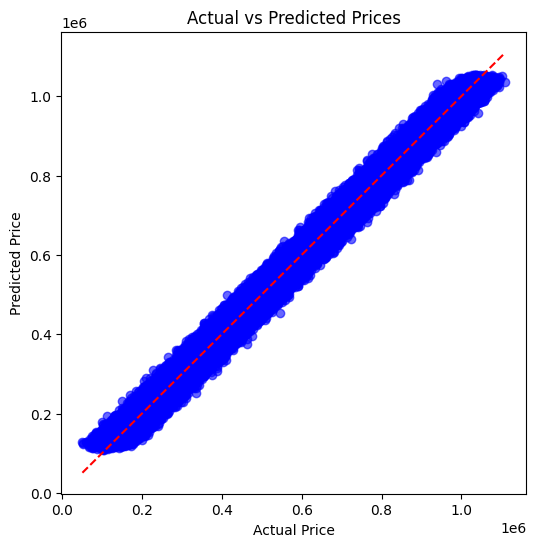

In [ ]:
import matplotlib.pyplot as plt

# After training and predicting
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal fit line
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.show()


In [ ]:
# Required Imports
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# Initialize Spark Session
spark = SparkSession.builder.appName("Property_Linear_Regression").getOrCreate()

# Load Property Dataset CSV
df = spark.read.csv("/content/01property.csv", header=True, inferSchema=True)

# Show schema and sample data
df.printSchema()
df.show(5)

# Check for null values
from pyspark.sql.functions import col, isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Select features & target columns (example)
# Independent variables:
features_sets = [
    ["Square_Footage", "Num_Bedrooms", "Num_Bathrooms", "Year_Built"],             # Model 1
    ["Square_Footage", "Num_Bedrooms", "Num_Bathrooms", "Lot_Size"],               # Model 2
    ["Square_Footage", "Num_Bedrooms", "Year_Built", "Lot_Size"],                  # Model 3
    ["Square_Footage", "Num_Bathrooms", "Year_Built", "Lot_Size"],                 # Model 4
    ["Square_Footage", "Num_Bedrooms", "Num_Bathrooms", "Year_Built", "Lot_Size"]  # Model 5 (all 5)
]

target_col = "Price"

# Function to train and evaluate model with given features
def train_evaluate(features):
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
    lr = LinearRegression(featuresCol="scaled_features", labelCol=target_col)
    pipeline = Pipeline(stages=[assembler, scaler, lr])

    # Split data
    train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

    # Fit model
    model = pipeline.fit(train_data)

    # Predict on test data
    predictions = model.transform(test_data)

    # Evaluate R-squared
    evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="r2")
    r2 = evaluator.evaluate(predictions)

    print(f"Features: {features}")
    print(f"R-squared on test data: {r2:.4f}\n")

    return r2

# Train & evaluate all models
results = {}
for i, feats in enumerate(features_sets, 1):
    r2_score = train_evaluate(feats)
    results[f"Model_{i}"] = {"features": feats, "r2": r2_score}

# Summary of all models
print("Model Comparison Summary:")
for model, info in results.items():
    print(f"{model}: Features = {info['features']}, R2 = {info['r2']:.4f}")

# Stop SparkSession when done
spark.stop()


root
 |-- Square_Footage: integer (nullable = true)
 |-- Num_Bedrooms: integer (nullable = true)
 |-- Num_Bathrooms: integer (nullable = true)
 |-- Year_Built: integer (nullable = true)
 |-- Lot_Size: integer (nullable = true)
 |-- Price: double (nullable = true)

+--------------+------------+-------------+----------+--------+------------------+
|Square_Footage|Num_Bedrooms|Num_Bathrooms|Year_Built|Lot_Size|             Price|
+--------------+------------+-------------+----------+--------+------------------+
|          1360|           2|            3|      1953|    7860| 303948.1373854071|
|          4272|           3|            3|      1997|    5292| 860386.2685075302|
|          3592|           4|            1|      1983|    9723| 734389.7538956215|
|           966|           6|            1|      1903|    4086| 226448.8070714377|
|          4926|           6|            4|      1944|    1081|1022486.2616704078|
+--------------+------------+-------------+----------+--------+--------

root
 |-- Square_Footage: integer (nullable = true)
 |-- Num_Bedrooms: integer (nullable = true)
 |-- Num_Bathrooms: integer (nullable = true)
 |-- Year_Built: integer (nullable = true)
 |-- Lot_Size: integer (nullable = true)
 |-- Price: double (nullable = true)

+--------------+------------+-------------+----------+--------+------------------+
|Square_Footage|Num_Bedrooms|Num_Bathrooms|Year_Built|Lot_Size|             Price|
+--------------+------------+-------------+----------+--------+------------------+
|          1360|           2|            3|      1953|    7860| 303948.1373854071|
|          4272|           3|            3|      1997|    5292| 860386.2685075302|
|          3592|           4|            1|      1983|    9723| 734389.7538956215|
|           966|           6|            1|      1903|    4086| 226448.8070714377|
|          4926|           6|            4|      1944|    1081|1022486.2616704078|
+--------------+------------+-------------+----------+--------+--------

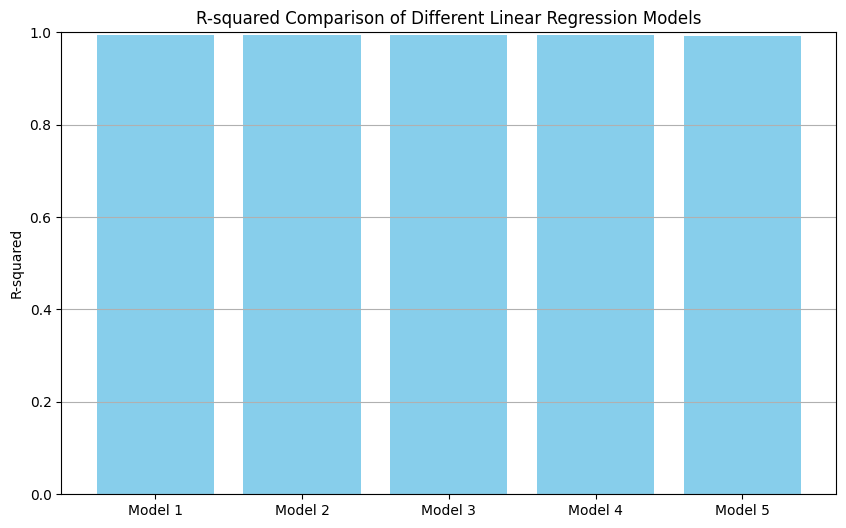


Best model: Model 1


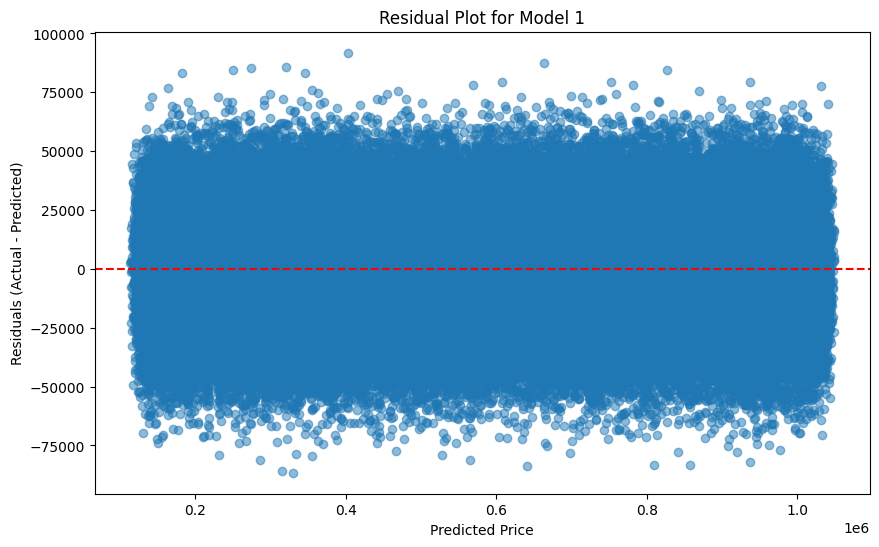

In [ ]:
# Install matplotlib for plotting
!pip3 install matplotlib

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

import matplotlib.pyplot as plt

# Initialize Spark session (adjust config if needed)
spark = SparkSession.builder.appName("Property_LinearRegression").master("local[*]").getOrCreate()

# Load your property dataset CSV - replace with your actual path
property_df = spark.read.csv("/content/01property.csv", header=True, inferSchema=True)

# Show schema and top rows
property_df.printSchema()
property_df.show(5)

# Select relevant columns for example
# Features candidates: Square_Footage, Num_Bedrooms, Num_Bathrooms, Year_Built, Lot_Size
# Target: Price

# Check for null values
from pyspark.sql.functions import col, isnan, when, count
property_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in property_df.columns]).show()

# Assume no nulls, otherwise handle them

# We'll create different feature sets to compare
feature_sets = {
    "Model 1": ["Square_Footage", "Num_Bedrooms", "Num_Bathrooms", "Year_Built", "Lot_Size"],
    "Model 2": ["Square_Footage", "Num_Bedrooms", "Num_Bathrooms", "Year_Built"],
    "Model 3": ["Square_Footage", "Num_Bedrooms", "Num_Bathrooms"],
    "Model 4": ["Square_Footage", "Num_Bedrooms"],
    "Model 5": ["Square_Footage"]
}

r2_scores = {}

for model_name, features in feature_sets.items():
    print(f"\nTraining {model_name} with features: {features}")

    # VectorAssembler for features
    assembler = VectorAssembler(inputCols=features, outputCol="features_vector")

    # StandardScaler for feature scaling
    scaler = StandardScaler(inputCol="features_vector", outputCol="scaled_features")

    # Linear Regression model setup
    lr = LinearRegression(featuresCol="scaled_features", labelCol="Price")

    # Pipeline
    pipeline = Pipeline(stages=[assembler, scaler, lr])

    # Train-test split (e.g. 80-20 split)
    train_data, test_data = property_df.randomSplit([0.8, 0.2], seed=42)

    # Fit model
    model = pipeline.fit(train_data)

    # Predict on test data
    predictions = model.transform(test_data)

    # Evaluate using R-squared
    evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="r2")
    r2 = evaluator.evaluate(predictions)
    r2_scores[model_name] = r2

    print(f"{model_name} R-squared: {r2:.4f}")

# Plot R-squared comparison bar chart
plt.figure(figsize=(10,6))
plt.bar(r2_scores.keys(), r2_scores.values(), color='skyblue')
plt.ylabel("R-squared")
plt.title("R-squared Comparison of Different Linear Regression Models")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# OPTIONAL: Residual plot for best model
best_model_name = max(r2_scores, key=r2_scores.get)
print(f"\nBest model: {best_model_name}")

# Retrain best model to get predictions
features_best = feature_sets[best_model_name]
assembler_best = VectorAssembler(inputCols=features_best, outputCol="features_vector")
scaler_best = StandardScaler(inputCol="features_vector", outputCol="scaled_features")
lr_best = LinearRegression(featuresCol="scaled_features", labelCol="Price")
pipeline_best = Pipeline(stages=[assembler_best, scaler_best, lr_best])

train_data, test_data = property_df.randomSplit([0.8, 0.2], seed=42)
model_best = pipeline_best.fit(train_data)
predictions_best = model_best.transform(test_data)

# Collect predictions and labels for plotting residuals
results_pd = predictions_best.select("prediction", "Price").toPandas()
results_pd['residuals'] = results_pd['Price'] - results_pd['prediction']

plt.figure(figsize=(10,6))
plt.scatter(results_pd['prediction'], results_pd['residuals'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title(f"Residual Plot for {best_model_name}")
plt.show()

# Stop Spark when done
spark.stop()


root
 |-- Square_Footage: integer (nullable = true)
 |-- Num_Bedrooms: integer (nullable = true)
 |-- Num_Bathrooms: integer (nullable = true)
 |-- Year_Built: integer (nullable = true)
 |-- Lot_Size: integer (nullable = true)
 |-- Price: double (nullable = true)

+--------------+------------+-------------+----------+--------+------------------+
|Square_Footage|Num_Bedrooms|Num_Bathrooms|Year_Built|Lot_Size|             Price|
+--------------+------------+-------------+----------+--------+------------------+
|          1360|           2|            3|      1953|    7860| 303948.1373854071|
|          4272|           3|            3|      1997|    5292| 860386.2685075302|
|          3592|           4|            1|      1983|    9723| 734389.7538956215|
|           966|           6|            1|      1903|    4086| 226448.8070714377|
|          4926|           6|            4|      1944|    1081|1022486.2616704078|
+--------------+------------+-------------+----------+--------+--------

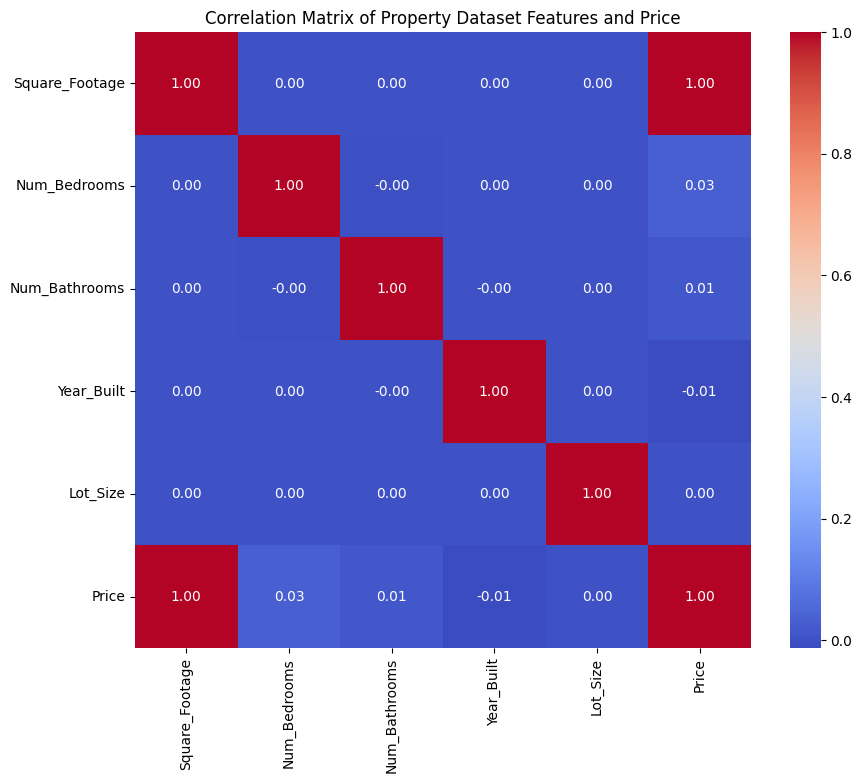


Training Model 1 with features: ['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Year_Built', 'Lot_Size']
Model 1 R-squared: 0.9941

Training Model 2 with features: ['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms', 'Year_Built']
Model 2 R-squared: 0.9941

Training Model 3 with features: ['Square_Footage', 'Num_Bedrooms', 'Num_Bathrooms']
Model 3 R-squared: 0.9939

Training Model 4 with features: ['Square_Footage', 'Num_Bedrooms']
Model 4 R-squared: 0.9937

Training Model 5 with features: ['Square_Footage']
Model 5 R-squared: 0.9927


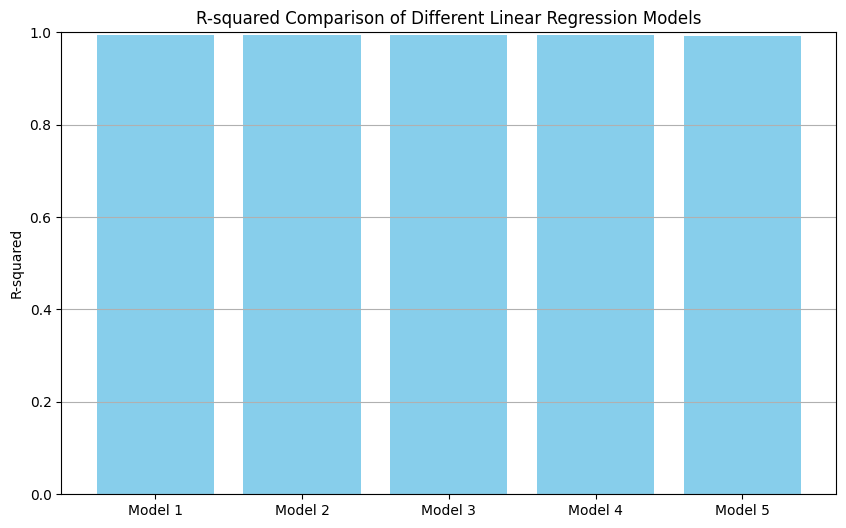


Best model: Model 1


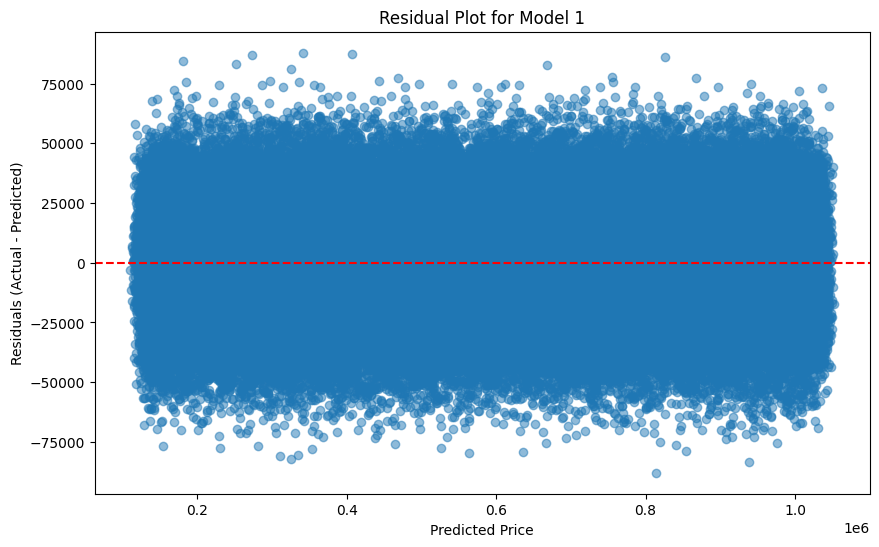

In [ ]:
# Install matplotlib for plotting if not installed
!pip3 install matplotlib seaborn

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("Property_LinearRegression").master("local[*]").getOrCreate()

# Load your property dataset CSV - replace with your actual path
property_df = spark.read.csv("/content/01property.csv", header=True, inferSchema=True)

# Show schema and top rows
property_df.printSchema()
property_df.show(5)

# Columns to use (features + target)
features = ["Square_Footage", "Num_Bedrooms", "Num_Bathrooms", "Year_Built", "Lot_Size"]
target = "Price"

# Calculate correlation matrix for features + target

# Select numeric columns only
corr_cols = features + [target]

# Convert to pandas dataframe for easier correlation matrix calc & plotting
pdf_corr = property_df.select(corr_cols).toPandas()

# Compute correlation matrix
corr_matrix = pdf_corr.corr()

# Plot correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar=True)
plt.title("Correlation Matrix of Property Dataset Features and Price")
plt.show()

# Now run regression models (same as before)
feature_sets = {
    "Model 1": ["Square_Footage", "Num_Bedrooms", "Num_Bathrooms", "Year_Built", "Lot_Size"],
    "Model 2": ["Square_Footage", "Num_Bedrooms", "Num_Bathrooms", "Year_Built"],
    "Model 3": ["Square_Footage", "Num_Bedrooms", "Num_Bathrooms"],
    "Model 4": ["Square_Footage", "Num_Bedrooms"],
    "Model 5": ["Square_Footage"]
}

r2_scores = {}

for model_name, feat in feature_sets.items():
    print(f"\nTraining {model_name} with features: {feat}")

    assembler = VectorAssembler(inputCols=feat, outputCol="features_vector")
    scaler = StandardScaler(inputCol="features_vector", outputCol="scaled_features")
    lr = LinearRegression(featuresCol="scaled_features", labelCol=target)
    pipeline = Pipeline(stages=[assembler, scaler, lr])

    train_data, test_data = property_df.randomSplit([0.8, 0.2], seed=42)
    model = pipeline.fit(train_data)
    predictions = model.transform(test_data)

    evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")
    r2 = evaluator.evaluate(predictions)
    r2_scores[model_name] = r2

    print(f"{model_name} R-squared: {r2:.4f}")

# Plot R-squared comparison
plt.figure(figsize=(10,6))
plt.bar(r2_scores.keys(), r2_scores.values(), color='skyblue')
plt.ylabel("R-squared")
plt.title("R-squared Comparison of Different Linear Regression Models")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# Residual plot for best model
best_model_name = max(r2_scores, key=r2_scores.get)
print(f"\nBest model: {best_model_name}")

features_best = feature_sets[best_model_name]
assembler_best = VectorAssembler(inputCols=features_best, outputCol="features_vector")
scaler_best = StandardScaler(inputCol="features_vector", outputCol="scaled_features")
lr_best = LinearRegression(featuresCol="scaled_features", labelCol=target)
pipeline_best = Pipeline(stages=[assembler_best, scaler_best, lr_best])

train_data, test_data = property_df.randomSplit([0.8, 0.2], seed=42)
model_best = pipeline_best.fit(train_data)
predictions_best = model_best.transform(test_data)

# Collect predictions and labels for plotting residuals
results_pd = predictions_best.select("prediction", "Price").toPandas()
results_pd['residuals'] = results_pd['Price'] - results_pd['prediction']

plt.figure(figsize=(10,6))
plt.scatter(results_pd['prediction'], results_pd['residuals'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title(f"Residual Plot for {best_model_name}")
plt.show()